### **Exploratory Data Analysis**

In this workbook, we will discover some fundamental EDA techniques for text data:
- Distribution Plots
- xxx
- xxx

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import unicodedata
import collections

from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

In [3]:
df_processed_full = pd.read_excel("amazon_review_processed_full.xlsx")
df_processed_full.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,title_word_count,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,ID
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,easi instal work great,True,0.0,False,...,2,38,11,3.875000,5.000000,3,0,Canon,work great easi instal work great,1
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,slower speed im use old model 8600 new 9015e s...,True,0.0,False,...,4,460,23,4.835443,5.000000,19,0,HP,spunki mid size slower speed im use old model ...,2
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0.0,False,...,2,7,12,3.000000,5.500000,0,0,Canon,i,3
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag know he talk,yup slam upgrad paid littl front equival throw...,True,12.0,False,...,6,469,34,4.595238,4.833333,31,2,Epson,shag know he talk yup slam upgrad paid littl f...,4
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendli,would think someth simpl reconnect wifi would ...,True,0.0,False,...,3,861,17,4.387500,5.000000,71,0,HP,user friendli would think someth simpl reconne...,5


In [4]:
df_processed_full.describe()

,Review date,Review rating,People_find_helpful,list price,rating count,overall rating,content_word_count,title_word_count,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,ID
count,10209,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000,10209.000000
mean,2022-11-02 18:38:32.547752192,3.084729,4.683612,201.352083,11595.403076,4.161926,85.707807,5.045254,455.495543,27.783916,4.420507,5.049198,34.220492,1.247527,5105.000000
min,2016-03-25 00:00:00,1.000000,0.000000,79.990000,285.000000,4.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000
25%,2022-06-24 00:00:00,1.000000,0.000000,129.990000,1896.000000,4.100000,24.000000,2.000000,126.000000,14.000000,4.111111,4.000000,8.000000,0.000000,2553.000000
50%,2023-02-09 00:00:00,3.000000,0.000000,159.990000,4338.000000,4.100000,54.000000,4.000000,285.000000,23.000000,4.365854,4.750000,21.000000,1.000000,5105.000000
75%,2023-06-07 00:00:00,5.000000,3.000000,239.990000,9872.000000,4.200000,109.000000,7.000000,574.000000,36.000000,4.642857,5.750000,44.000000,2.000000,7657.000000
max,2023-09-13 00:00:00,5.000000,990.000000,549.990000,53646.000000,4.400000,1439.000000,25.000000,8042.000000,127.000000,10.000000,22.000000,597.000000,12.000000,10209.000000
std,NaN,1.587869,23.275835,108.597911,17373.701014,0.099770,102.562293,3.567902,554.850041,19.129711,0.581190,1.610166,42.824573,1.632038,2947.228783


In [5]:
df_processed_full['Review Model'] = df_processed_full['Review Model'].astype(str)
df_processed_full['Retailer'] = df_processed_full['Retailer'].astype(str)
df_processed_full['Review title'] = df_processed_full['Review title'].astype(str)
df_processed_full['Review Content'] = df_processed_full['Review Content'].astype(str)
df_processed_full['People_find_helpful'] = df_processed_full['People_find_helpful'].astype(str)
df_processed_full["vine or not"] = df_processed_full["vine or not"].astype('bool')
df_processed_full["Verified Purchase or not"] = df_processed_full["Verified Purchase or not"].astype('bool')

#### <font color=#FFB703> **Grouping into Positive / Negative** </font>

In [6]:
def categorize_rating(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df_processed_full['Rating Category'] = df_processed_full['Review rating'].apply(categorize_rating)

#### <font color=#FFB703> **Tokenising** </font>

In [7]:
# Tokenisation (Review Content)
df_processed_full['Tokenized Content'] = df_processed_full['Review Content'].apply(lambda x: word_tokenize(str(x)) if isinstance(x, str) else [])
df_processed_full[['Review Content', 'Tokenized Content']].head(5)

,Review Content,Tokenized Content
0,easi instal work great,"[easi, instal, work, great]"
1,slower speed im use old model 8600 new 9015e s...,"[slower, speed, im, use, old, model, 8600, new..."
2,i,[i]
3,yup slam upgrad paid littl front equival throw...,"[yup, slam, upgrad, paid, littl, front, equiva..."
4,would think someth simpl reconnect wifi would ...,"[would, think, someth, simpl, reconnect, wifi,..."


In [8]:
# Tokenisation (Review title)
# df_processed_full['Tokenized title'] = df_processed_full['Review title'].apply(lambda x: word_tokenize(str(x)) if isinstance(x, str) else [])
# df_processed_full[['Review title', 'Tokenized Content']].head(5)

#### <font color=#FFB703> **Feature Engineering** </font>

<font color=#61BEB0>**Length:**</font>

In [9]:
df_processed_full['length'] = df_processed_full['Review Content'].apply(len)

<font color=#61BEB0>**Text Polarity:**</font>

In [10]:
# Calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

df_processed_full['polarity'] = df_processed_full['Review Content'].apply(get_polarity)

<font color=#61BEB0>**Text Subjectivity:**</font>

In [11]:
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

df_processed_full['subjectivity'] = df_processed_full['Review Content'].apply(get_subjectivity)

<font color=#61BEB0>**Summarised:**</font>

In [12]:
df_processed_full[['length','polarity','subjectivity']].describe()

,length,polarity,subjectivity
count,10209.000000,10209.000000,10209.000000
mean,222.586443,0.153191,0.439266
std,274.737611,0.274742,0.243380
min,1.000000,-1.000000,0.000000
25%,61.000000,0.000000,0.310000
50%,137.000000,0.111667,0.466667
75%,279.000000,0.295238,0.600000
max,3968.000000,1.000000,1.000000


<font color=#61BEB0>**Visualising Polarity and Subjectivity:**</font>

C:\Users\peace\AppData\Local\Temp\ipykernel_12692\132936889.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_processed_full['polarity'], color='#61BEB0')
C:\Users\peace\AppData\Local\Temp\ipykernel_12692\132936889.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_processed_full['subje

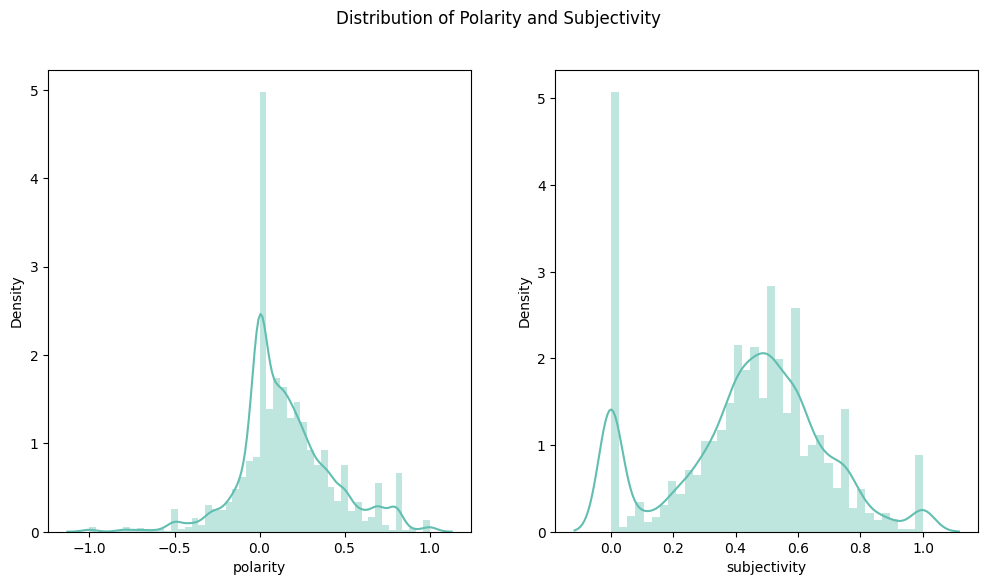

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.distplot(df_processed_full['polarity'], color='#61BEB0')

plt.subplot(1, 2, 2)
sns.distplot(df_processed_full['subjectivity'], color='#61BEB0')

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

<font color=#61BEB0>**Relation between Polarity and Subjectivity:**</font>

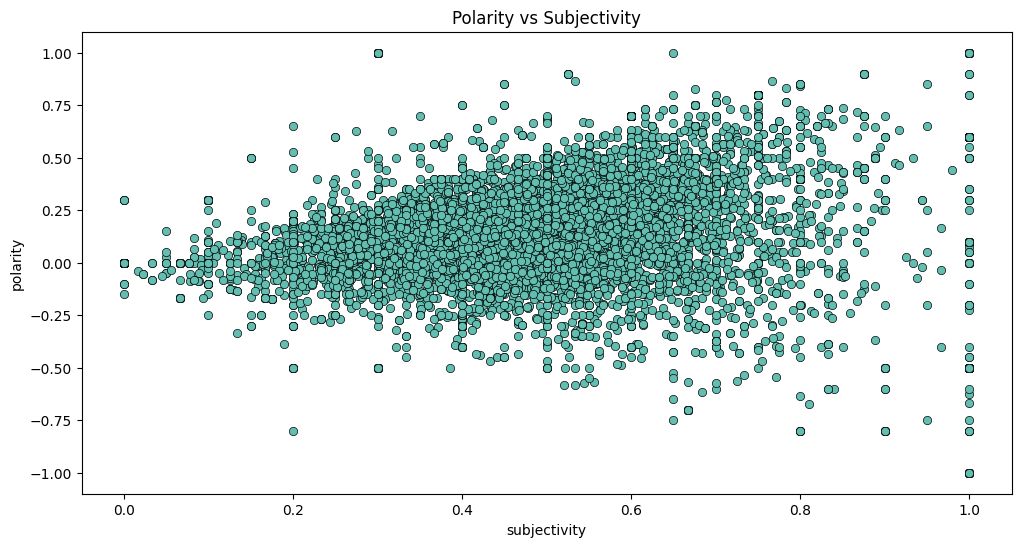

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(y= df_processed_full['polarity'], x=df_processed_full['subjectivity'], color='#61BEB0', edgecolor='black')
plt.title('Polarity vs Subjectivity')
plt.show()

#### <font color=#FFB703> **Visualising Most Frequent Words** </font>

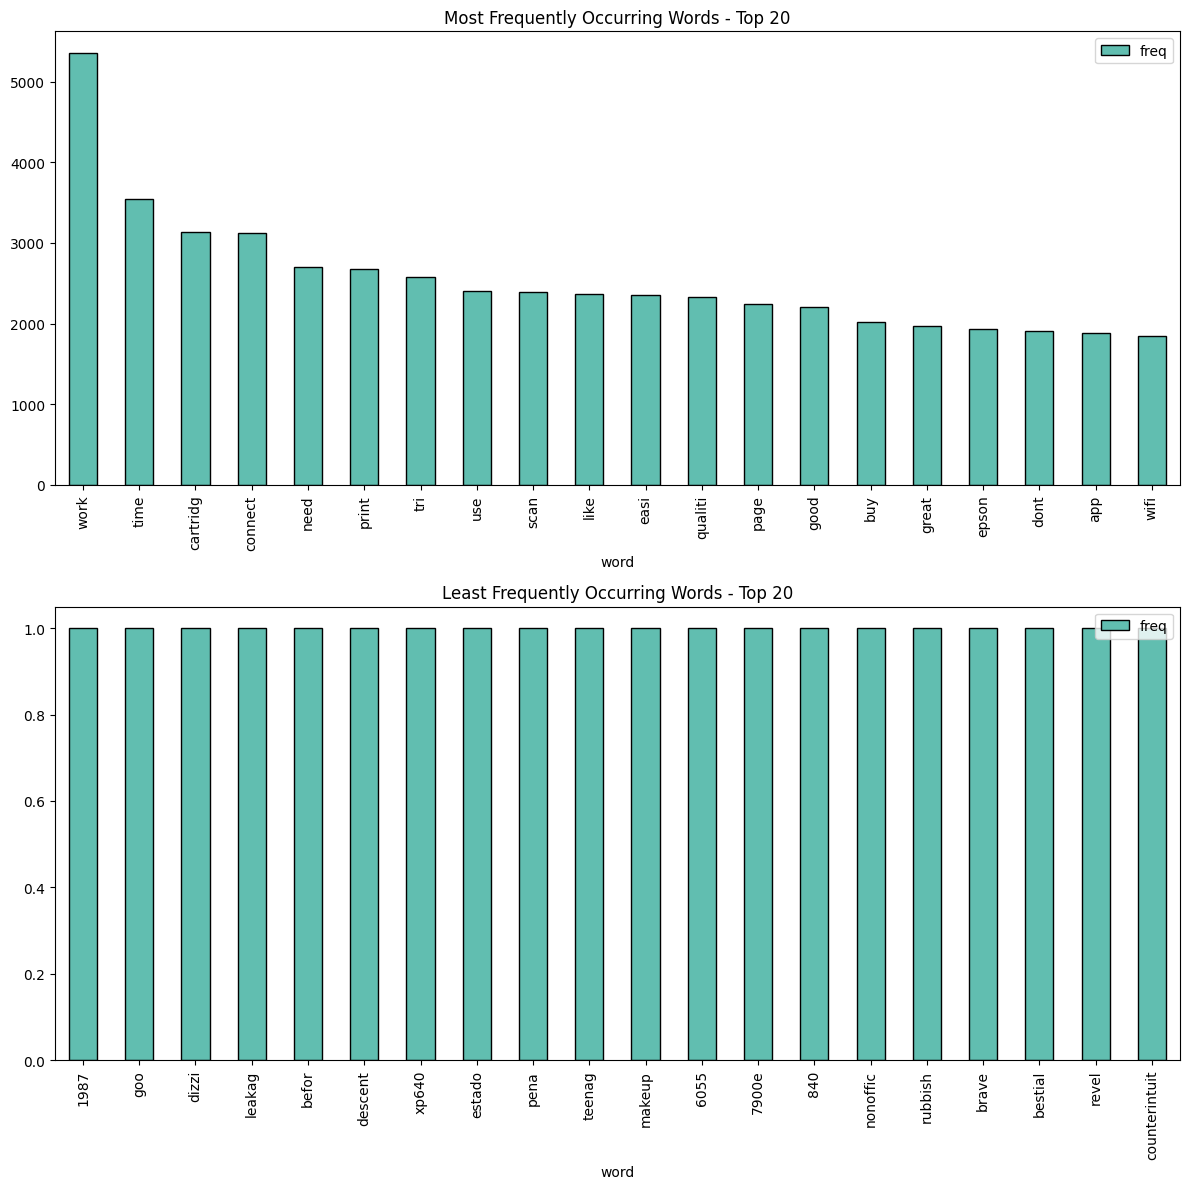

In [15]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_processed_full['Review Content'])
sum_words = words.sum(axis=0)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the most frequently occurring words (top 20)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(20).plot(x='word', y='freq', kind='bar', ax=axes[0], color='#61BEB0', edgecolor='black')
axes[0].set_title("Most Frequently Occurring Words - Top 20")

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.tail(20).plot(x='word', y='freq', kind='bar', ax=axes[1], color='#61BEB0', edgecolor='black')
axes[1].set_title("Least Frequently Occurring Words - Top 20")

plt.tight_layout()
plt.show()

#### <font color=#FFB703> **Visualising nGrams** </font>

In [16]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<font color=#61BEB0>**Top Unigrams:**</font>

In [17]:
text = str(df_processed_full['Review Content'])
tokenized = text.split()

# and get a list of all the bi-grams
esBigrams = ngrams(tokenized, 1)

# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(esBigrams)

esBigramFreq.most_common(10)

[(('can',), 5),
 (('would',), 2),
 (('...',), 2),
 (('0',), 1),
 (('easi',), 1),
 (('instal',), 1),
 (('work',), 1),
 (('great',), 1),
 (('1',), 1),
 (('slower',), 1)]

<font color=#61BEB0>**Top Bigrams:**</font>

In [18]:
text = str(df_processed_full['Review Content'])
tokenized = text.split()

# and get a list of all the bi-grams
esBigrams = ngrams(tokenized, 2)

# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(esBigrams)

esBigramFreq.most_common(10)

[(('0', 'easi'), 1),
 (('easi', 'instal'), 1),
 (('instal', 'work'), 1),
 (('work', 'great'), 1),
 (('great', '1'), 1),
 (('1', 'slower'), 1),
 (('slower', 'speed'), 1),
 (('speed', 'im'), 1),
 (('im', 'use'), 1),
 (('use', 'old'), 1)]

<font color=#61BEB0>**Top Trigrams:**</font>

In [19]:
text = str(df_processed_full['Review Content'])
tokenized = text.split()

# and get a list of all the bi-grams
esTrigrams = ngrams(tokenized, 3)

# get the frequency of each bigram in our corpus
esTrigramFreq = collections.Counter(esTrigrams)

esTrigramFreq.most_common(10)

[(('0', 'easi', 'instal'), 1),
 (('easi', 'instal', 'work'), 1),
 (('instal', 'work', 'great'), 1),
 (('work', 'great', '1'), 1),
 (('great', '1', 'slower'), 1),
 (('1', 'slower', 'speed'), 1),
 (('slower', 'speed', 'im'), 1),
 (('speed', 'im', 'use'), 1),
 (('im', 'use', 'old'), 1),
 (('use', 'old', 'model'), 1)]

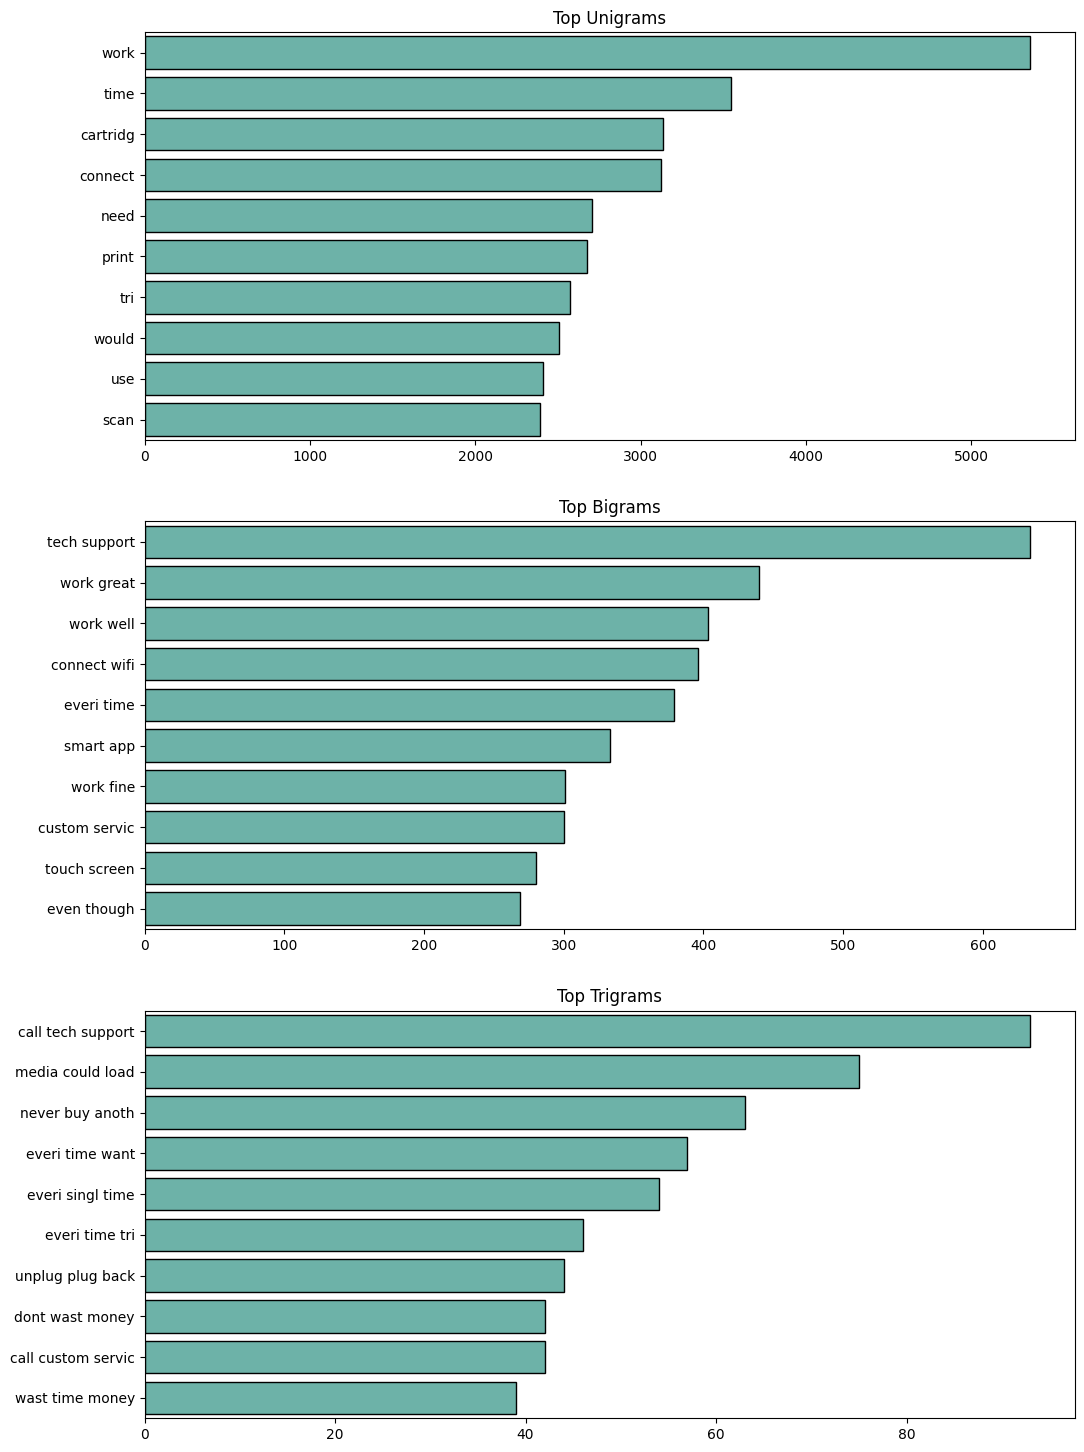

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

top_unigrams = get_top_ngram(df_processed_full['Review Content'], 1)[:10]
x, y = map(list, zip(*top_unigrams))
sns.barplot(x=y, y=x, ax=axes[0], color='#61BEB0', edgecolor='black')
axes[0].set_title("Top Unigrams")

top_bigrams = get_top_ngram(df_processed_full['Review Content'], 2)[:10]
x, y = map(list, zip(*top_bigrams))
sns.barplot(x=y, y=x, ax=axes[1], color='#61BEB0', edgecolor='black')
axes[1].set_title("Top Bigrams")

top_trigrams = get_top_ngram(df_processed_full['Review Content'], 3)[:10]
x, y = map(list, zip(*top_trigrams))
sns.barplot(x=y, y=x, ax=axes[2], color='#61BEB0', edgecolor='black')
axes[2].set_title("Top Trigrams")

plt.show()

#### <font color=#FFB703> **Word Cloud** </font>

<font color=#61BEB0>**Overall Word Cloud:**</font>

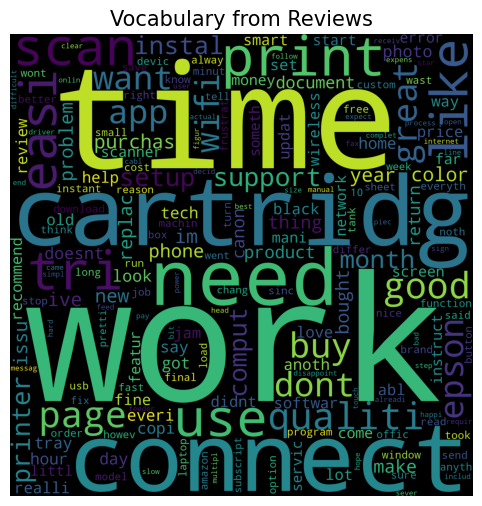

In [28]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_processed_full['Review Content'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 15)
plt.show()

<font color=#61BEB0>**Word cloud for each brand:**</font>

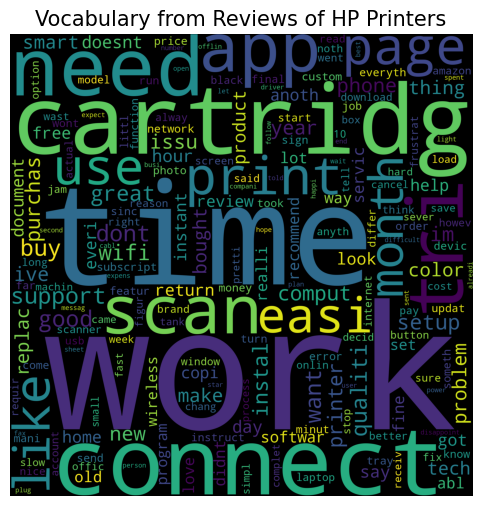

In [27]:
hp_words = cv.fit_transform(df_processed_full['Review Content'][df_processed_full['Brand']=="HP"])
hp_sum_words = hp_words.sum(axis=0)

hp_words_freq = [(word, hp_sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
hp_words_freq = sorted(hp_words_freq, key = lambda x: x[1], reverse = True)

hp_wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(hp_words_freq))

plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(hp_wordcloud)
plt.title("Vocabulary from Reviews of HP Printers", fontsize = 15)
plt.show()

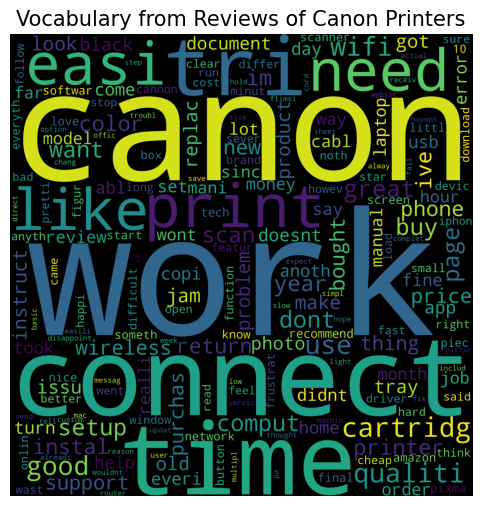

In [29]:
canon_words = cv.fit_transform(df_processed_full['Review Content'][df_processed_full['Brand']=="Canon"])
canon_sum_words = canon_words.sum(axis=0)

canon_words_freq = [(word, canon_sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
canon_words_freq = sorted(canon_words_freq, key = lambda x: x[1], reverse = True)

canon_wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(canon_words_freq))

plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(canon_wordcloud)
plt.title("Vocabulary from Reviews of Canon Printers", fontsize = 15)
plt.show()

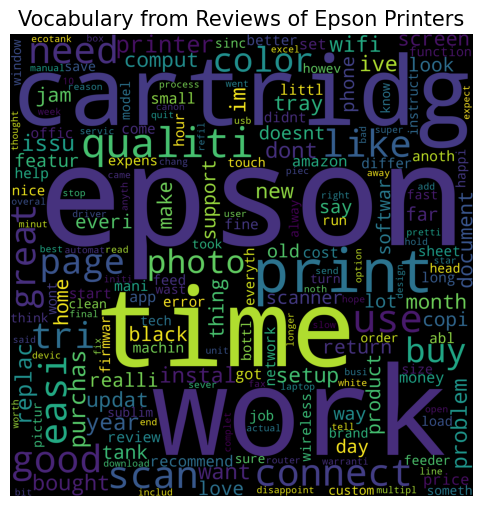

In [30]:
epson_words = cv.fit_transform(df_processed_full['Review Content'][df_processed_full['Brand']=="Epson"])
epson_sum_words = epson_words.sum(axis=0)

epson_words_freq = [(word, epson_sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
epson_words_freq = sorted(epson_words_freq, key = lambda x: x[1], reverse = True)

epson_wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(epson_words_freq))

plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(epson_wordcloud)
plt.title("Vocabulary from Reviews of Epson Printers", fontsize = 15)
plt.show()

#### <font color=#FFB703> **Counts** </font>

<font color=#61BEB0>**Character Count:**</font>

In [31]:
df_processed_full['char_count'] = df_processed_full['Review Content'].apply(len)

<font color=#61BEB0>**Word Count:**</font>

In [32]:
df_processed_full['word_count'] = df_processed_full['Review Content'].apply(lambda x: len(x.split()))

<font color=#61BEB0>**Word Density:**</font>

In [33]:
df_processed_full['word_density'] = df_processed_full['char_count'] / (df_processed_full['word_count']+1)

<font color=#61BEB0>**Summarised:**</font>

In [34]:
df_processed_full[['char_count','word_count','word_density']].describe()

,char_count,word_count,word_density
count,10209.000000,10209.000000,10209.000000
mean,222.586443,37.712802,5.394690
std,274.737611,45.939257,0.795480
min,1.000000,1.000000,0.500000
25%,61.000000,11.000000,5.150000
50%,137.000000,23.000000,5.581818
75%,279.000000,47.000000,5.875000
max,3968.000000,643.000000,9.392857


#### <font color=#FFB703> **Distribution Plots** </font>

<font color=#61BEB0>**Average number of token words (by positive / negative rating):**</font>

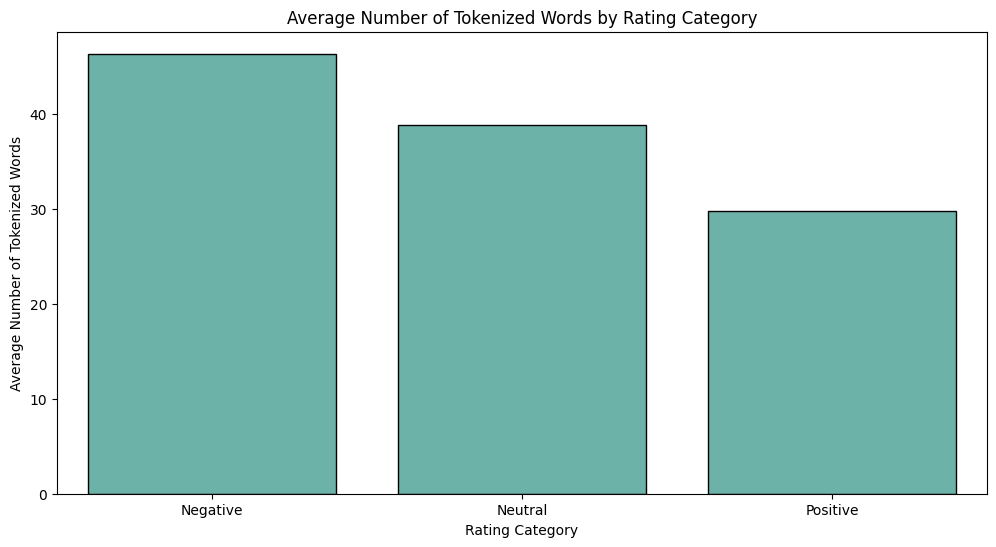

In [35]:
df_processed_full['Avg Token Words'] = df_processed_full['Tokenized Content'].apply(len)
overall_avg = df_processed_full.groupby('Rating Category')['Avg Token Words'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x = 'Rating Category', y = 'Avg Token Words', data = overall_avg, color='#61BEB0', edgecolor='black')
plt.title('Average Number of Tokenized Words by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Average Number of Tokenized Words')
plt.show()

<font color=#61BEB0>**Average number of characters:**</font>

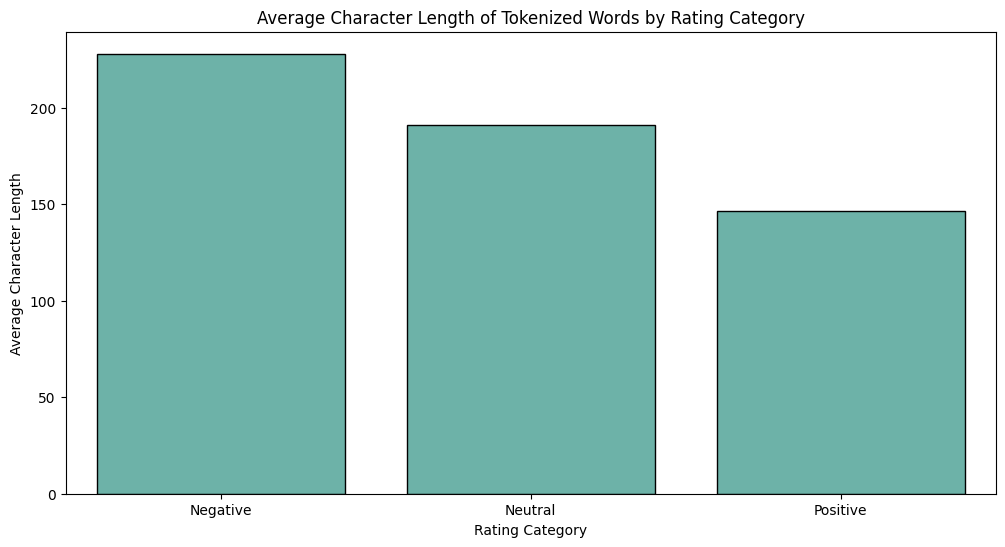

In [36]:
df_processed_full['Avg Char Length'] = df_processed_full['Tokenized Content'].apply(lambda x: sum(len(word) for word in x))

avg_lengths = df_processed_full.groupby('Rating Category')['Avg Char Length'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Rating Category', y='Avg Char Length', data=avg_lengths, color = '#61BEB0', edgecolor = 'black')
plt.title('Average Character Length of Tokenized Words by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Average Character Length')
plt.show()

<font color=#61BEB0>**Overall Rating Distribution:**</font>

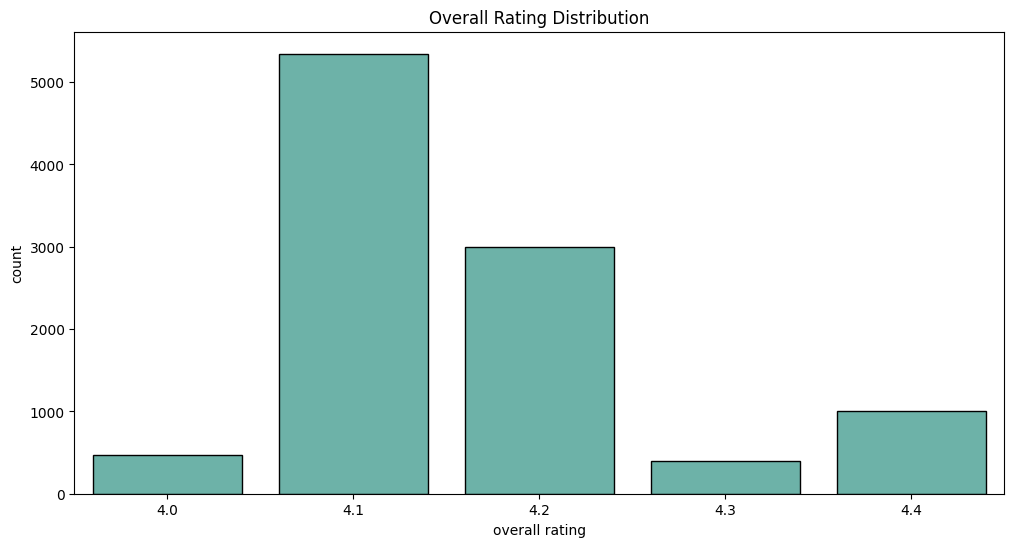

In [37]:
plt.figure(figsize=(12, 6))
sns.countplot(x='overall rating', data=df_processed_full, color = '#61BEB0', edgecolor = 'black')
plt.title('Overall Rating Distribution')
plt.show()

<font color=#61BEB0>**Review Distribution:**</font>

In [38]:
df_processed_full["Review rating"].value_counts()

Review rating
5    3011
1    2663
4    1642
2    1473
3    1420
Name: count, dtype: int64

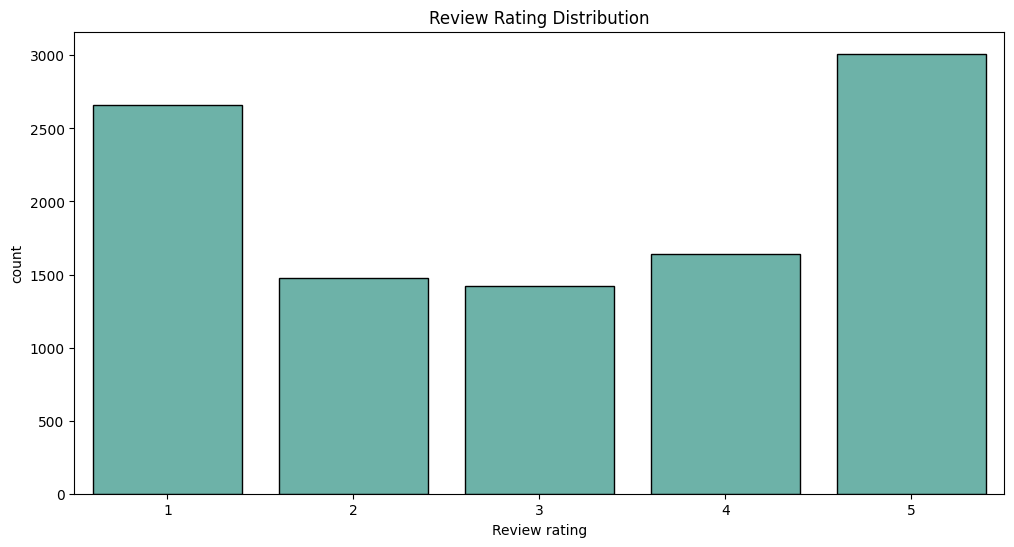

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Review rating', data=df_processed_full, color = '#61BEB0', edgecolor = 'black')
plt.title('Review Rating Distribution')
plt.show()

<Axes: xlabel='Review rating'>

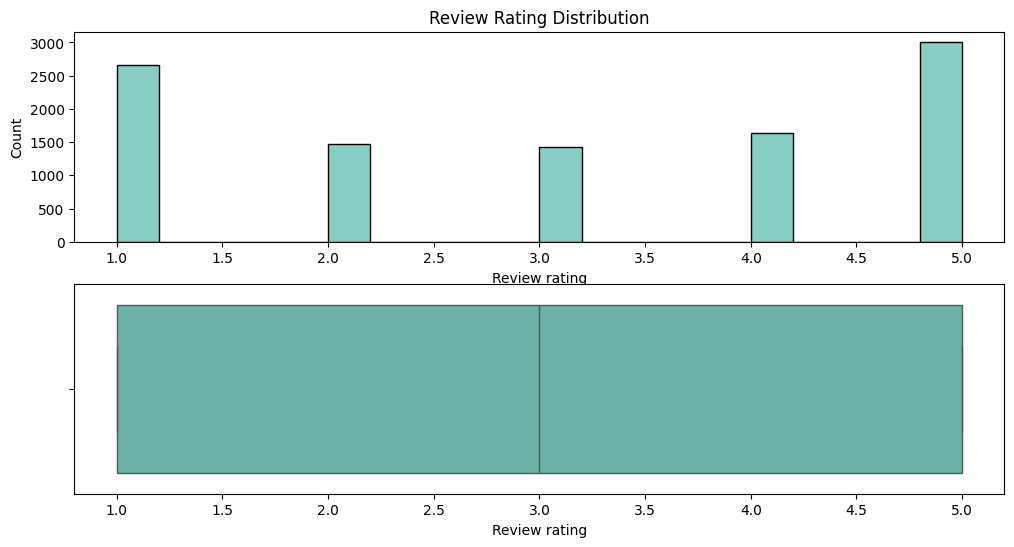

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
sns.histplot(df_processed_full['Review rating'], bins=20, kde=False, color = '#61BEB0', edgecolor= 'black')
plt.title('Review Rating Distribution')
plt.subplot(2, 1, 2)
sns.boxplot(x='Review rating', data=df_processed_full, color = '#61BEB0')

<font color=#61BEB0>**Rating Distribution by Brand:**</font>

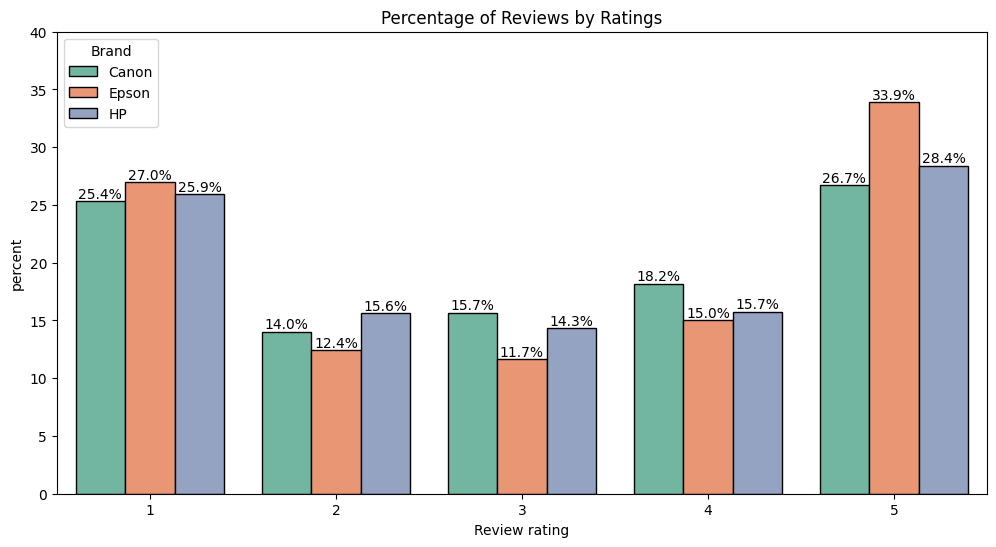

In [114]:
# Plot distribution of review rating by brand
rating_pr = df_processed_full.groupby("Brand")["Review rating"].value_counts(normalize=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()

plt.figure(figsize=(12, 6))
g = sns.barplot(x="Review rating", y='percent', hue="Brand", edgecolor = 'black', data=rating_pr, palette="Set2")
g.set_ylim(0, 40)

# Loop through the bars and add percentage labels
for p in g.patches:
    height = p.get_height()  # Get the height of the bar
    if height >= 1.0:  # Only label bars with percentages >= 1%
        txt = str(round(float(height), 1)) + '%'  # Convert to float and round to 1 decimal place
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = height
        g.text(txt_x, txt_y, txt, ha="center", va="bottom")

# Set the title for the plot
plt.title('Percentage of Reviews by Ratings')
plt.show()

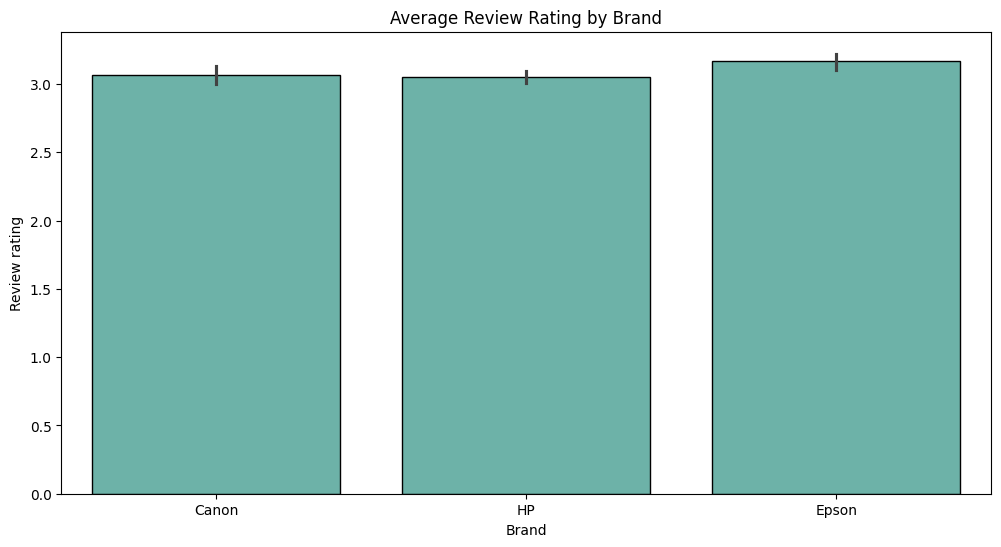

In [115]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_processed_full, x="Brand", y="Review rating", color = '#61BEB0', edgecolor = 'black')
plt.title('Average Review Rating by Brand')
plt.show()

<font color=#61BEB0>**Rating Distribution by Model:**</font>

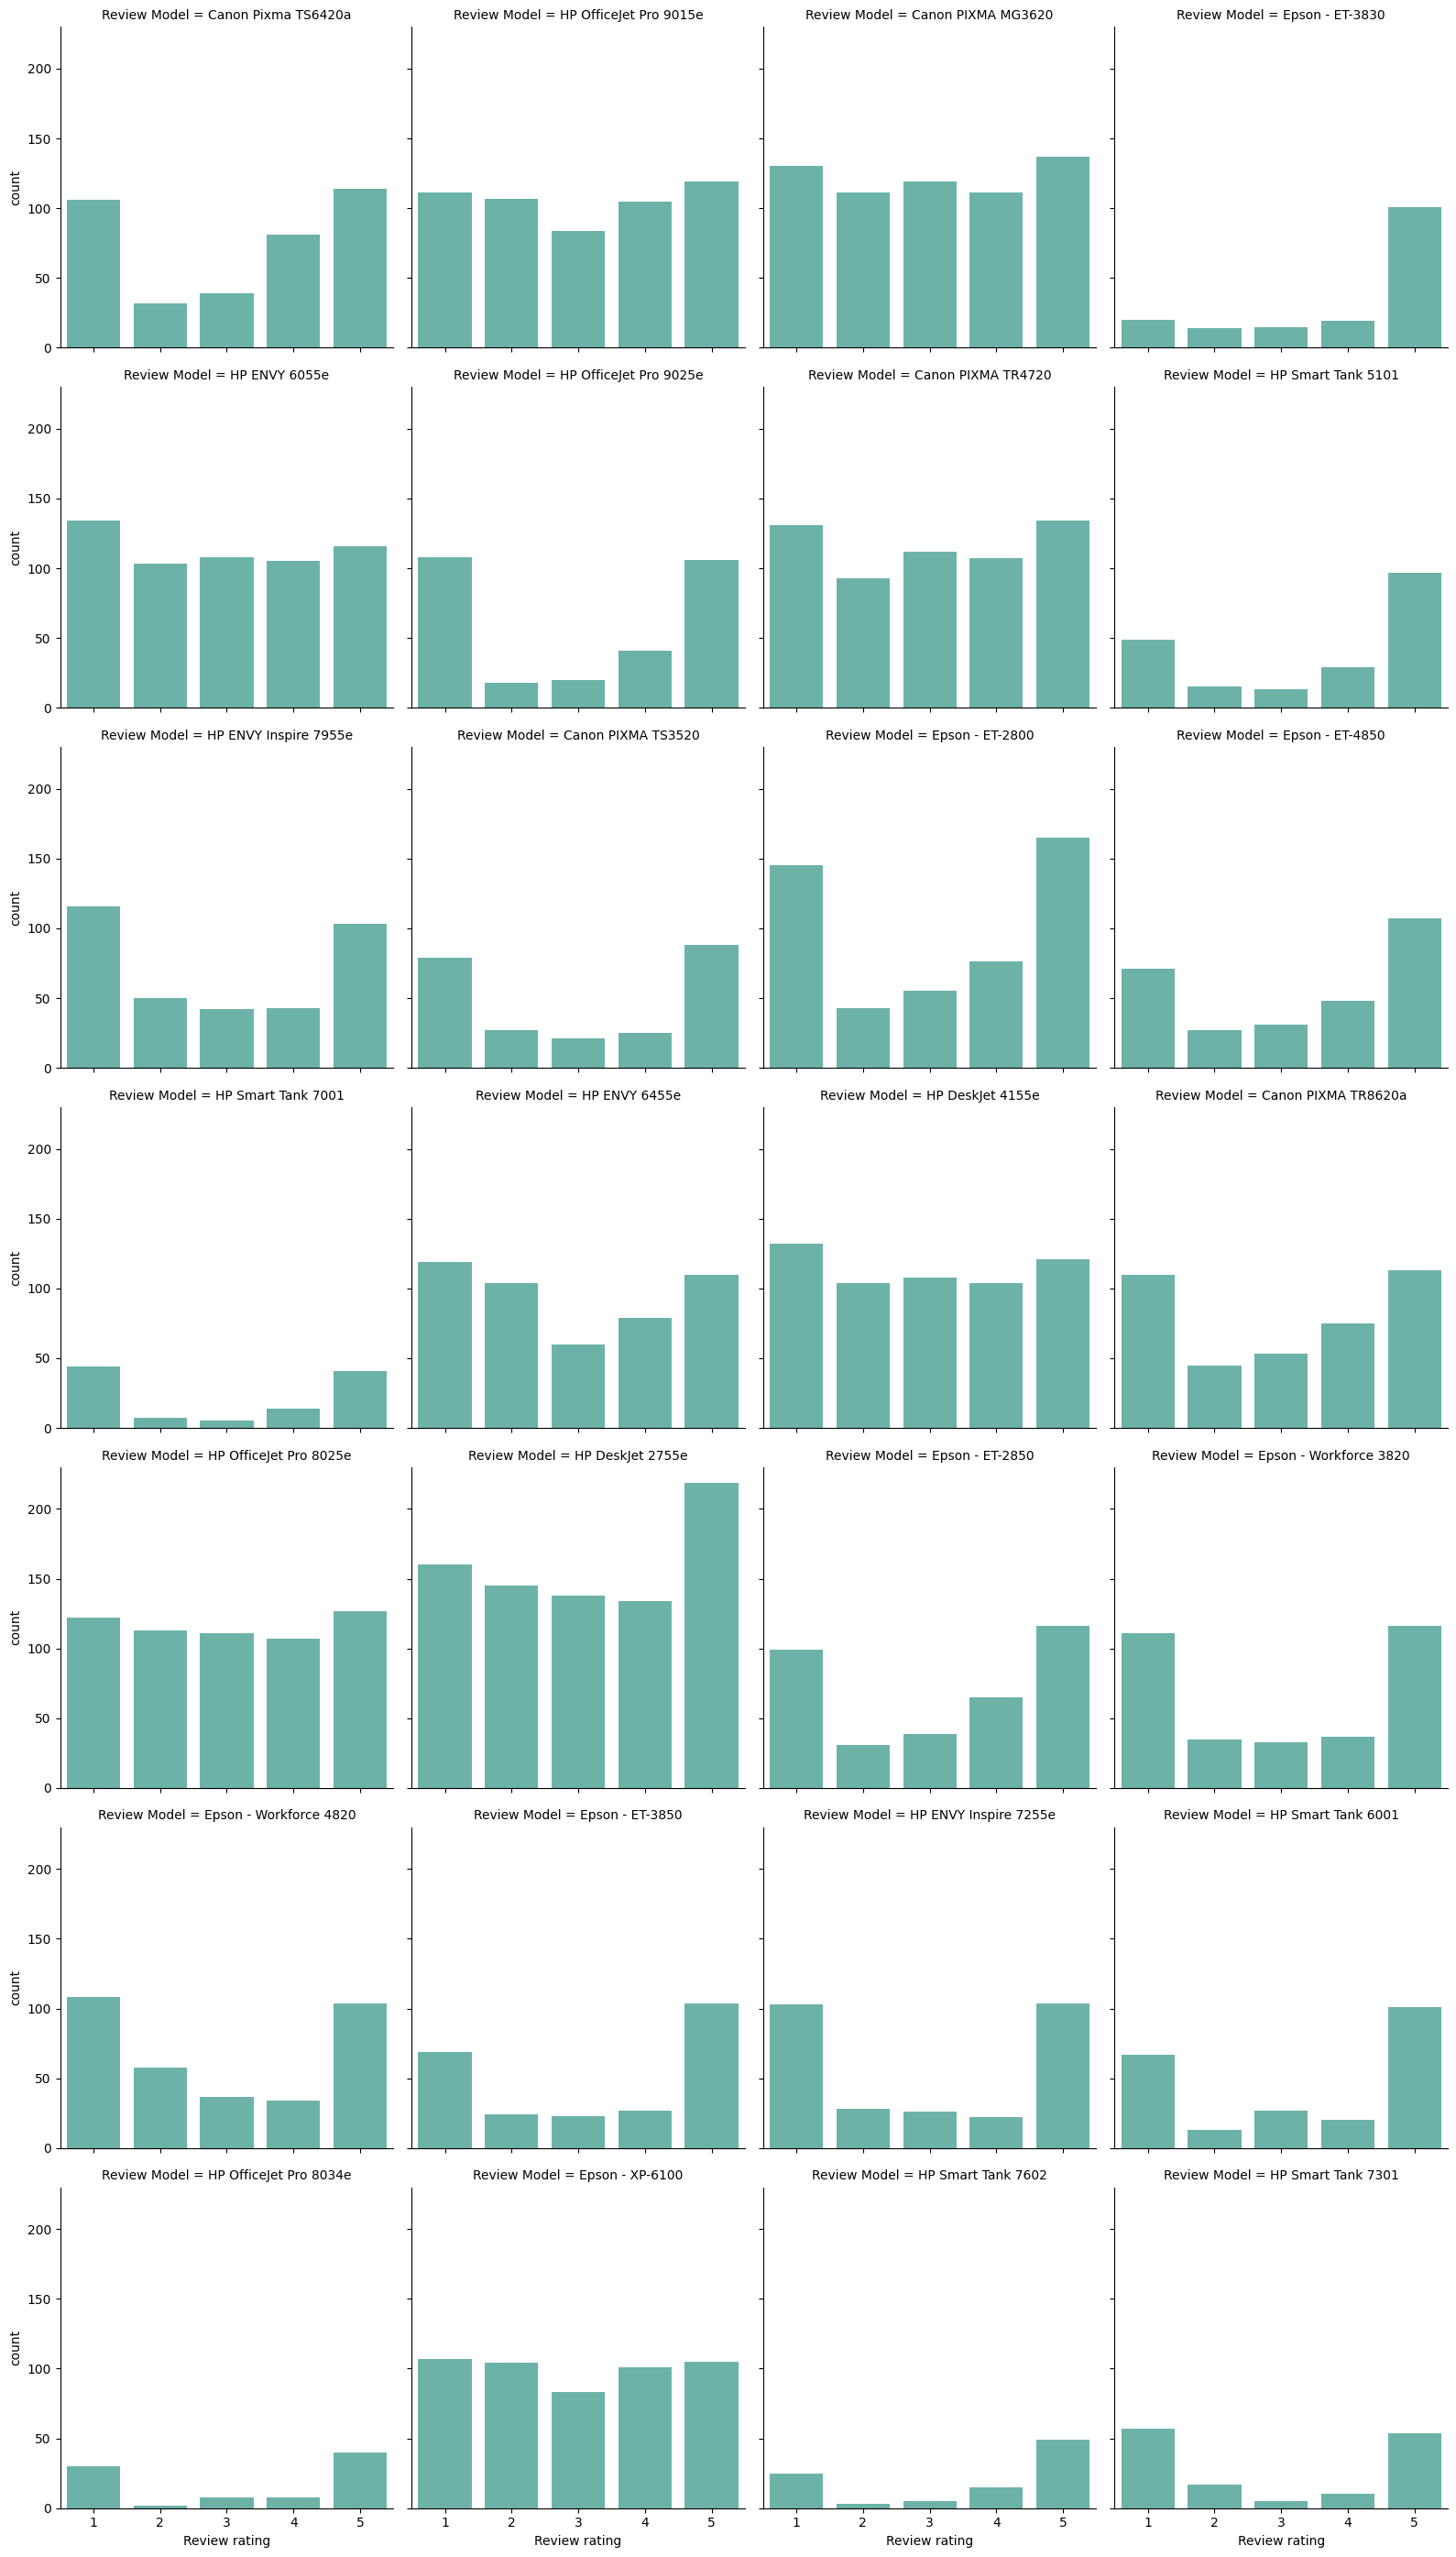

In [ ]:
#Rating distribution by model
sns.catplot(
    data=df_processed_full, x="Review rating", col="Review Model",
    kind="count", height=4, col_wrap = 4, color = '#61BEB0', edgecolor = 'black'
)
plt.show()

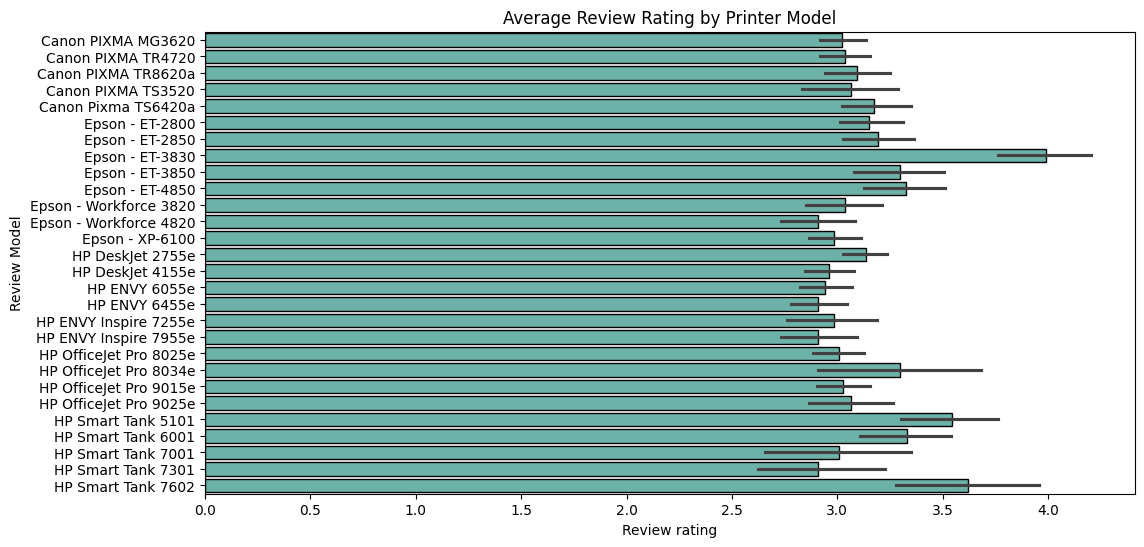

In [116]:
#plot average rating by model
plt.figure(figsize=(12, 6))
sns.barplot(data=df_processed_full, y="Review Model", x="Review rating", color = '#61BEB0', edgecolor = 'black',
            order = sorted(df_processed_full["Review Model"].unique()))
plt.title('Average Review Rating by Printer Model')
plt.show()

<font color=#61BEB0>**Rating Count Distribution:**</font>

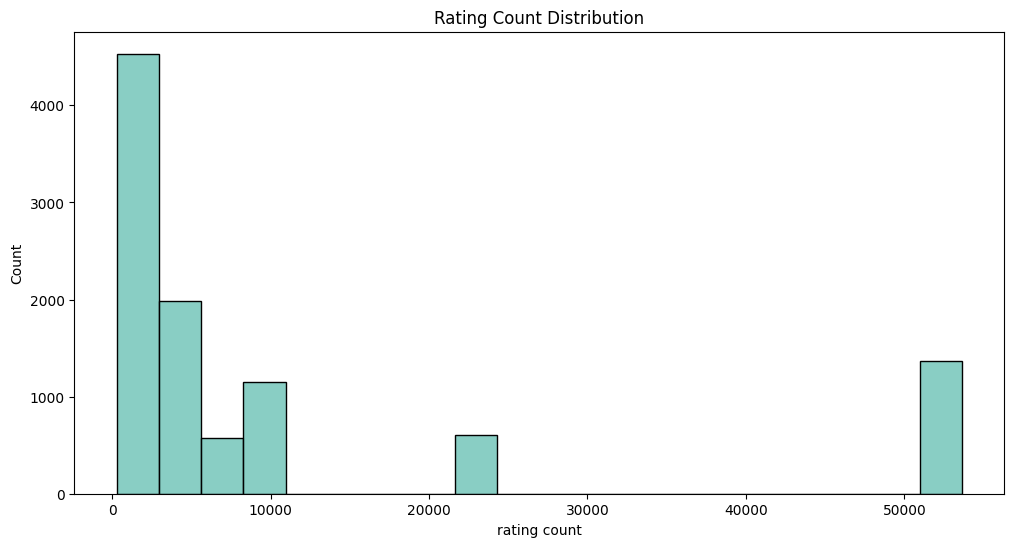

In [75]:
plt.figure(figsize=(12, 6))
sns.histplot(df_processed_full['rating count'], bins=20, kde=False, color = '#61BEB0')
plt.title('Rating Count Distribution')
plt.show()

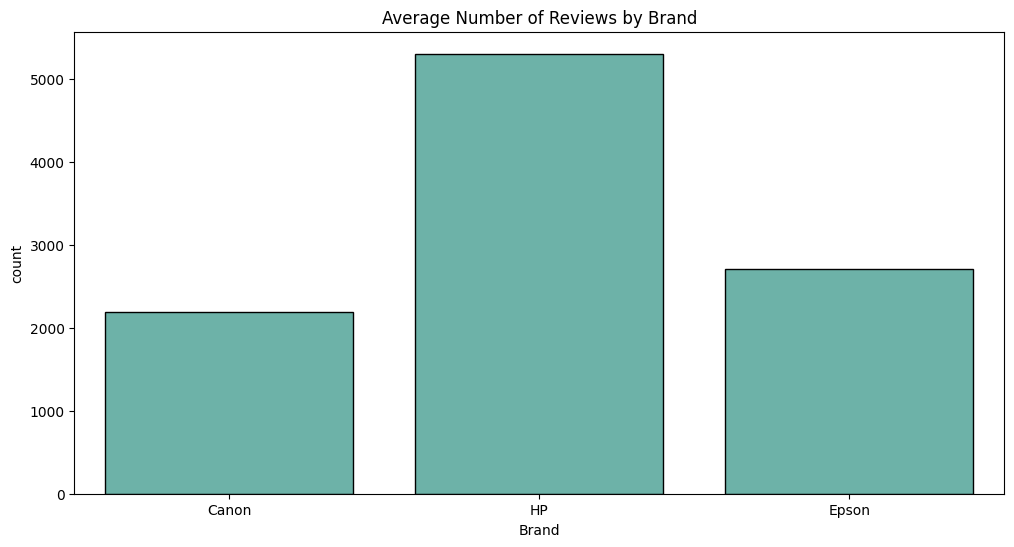

In [78]:
plt.figure(figsize=(12, 6))
sns.countplot(df_processed_full, x="Brand", color = '#61BEB0', edgecolor = 'black')
plt.title('Average Number of Reviews by Brand')
plt.show()

<font color=#61BEB0>**Word Distribution:**</font>

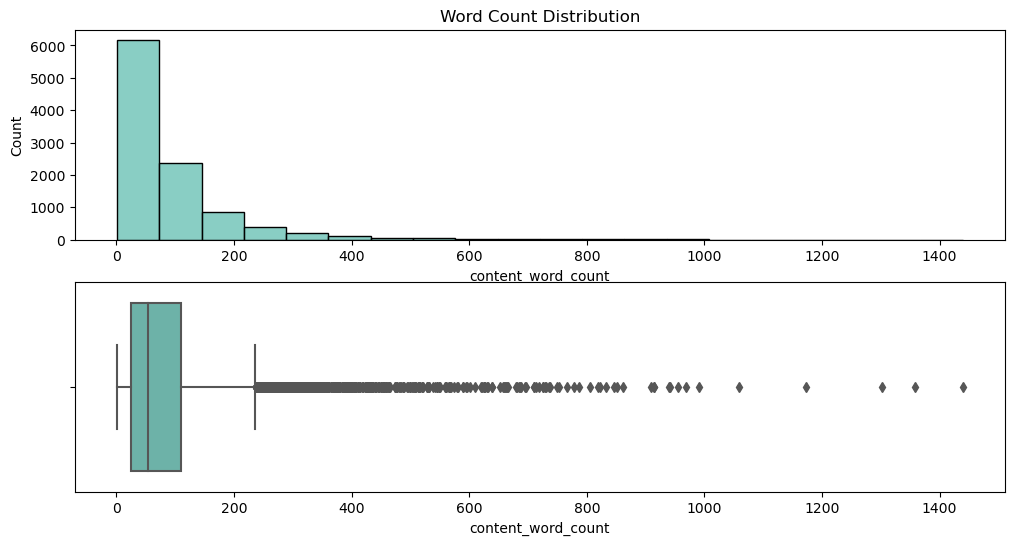

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
sns.histplot(df_processed_full['content_word_count'], bins=20, kde=False, color = '#61BEB0')
plt.title('Word Count Distribution')
plt.subplot(2, 1, 2)
sns.boxplot(x='content_word_count', data=df_processed_full, color = '#61BEB0')
plt.show()

<font color=#61BEB0>**Verified Purchase Distribution:**</font>

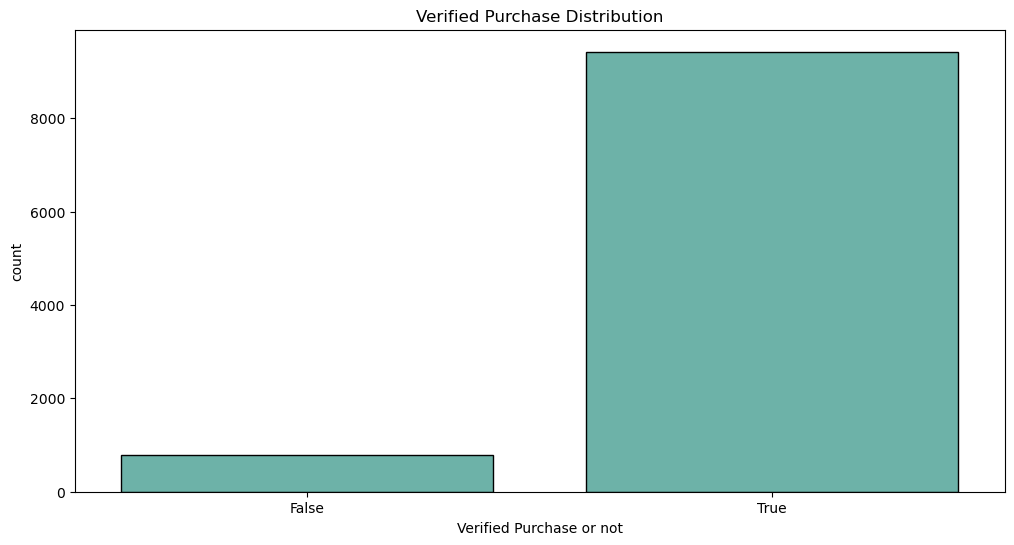

In [59]:
plt.figure(figsize=(12, 6))
sns.countplot(df_processed_full, x='Verified Purchase or not', color = '#61BEB0', edgecolor = 'black')
plt.title('Verified Purchase Distribution')
plt.show()

<font color=#61BEB0>**Vine or Not Distribution:**</font>

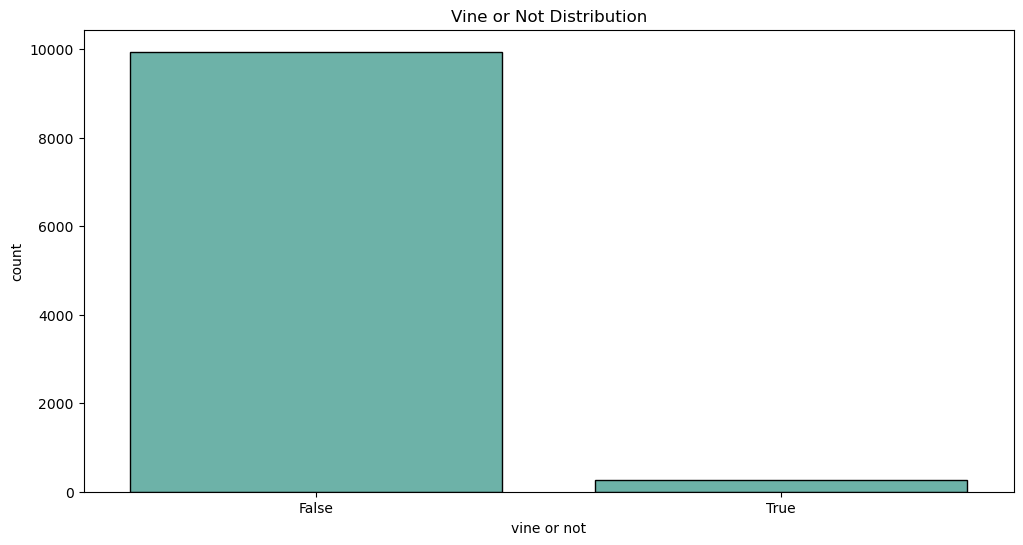

In [69]:
plt.figure(figsize=(12, 6))
sns.countplot(df_processed_full, x='vine or not', color = '#61BEB0', edgecolor = 'black')
plt.title('Vine or Not Distribution')
plt.show()

<font color=#61BEB0>**Review Date Distribution:**</font>

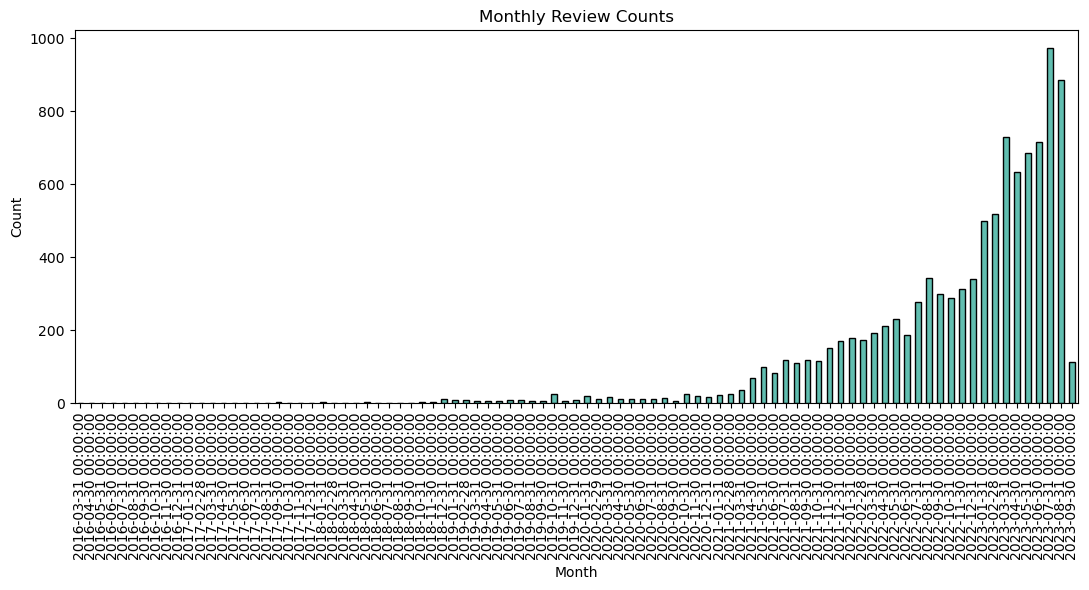

In [70]:
df_processed_full['Review date'] = pd.to_datetime(df_processed_full['Review date'])
df_time = df_processed_full.set_index('Review date')
monthly_counts = df_time.resample('M').size()

plt.figure(figsize=(11, 6))
monthly_counts.plot(kind='bar', color = '#61BEB0', edgecolor = 'black')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Review Counts')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

<font color=#61BEB0>**Correlation Heatmap:**</font>

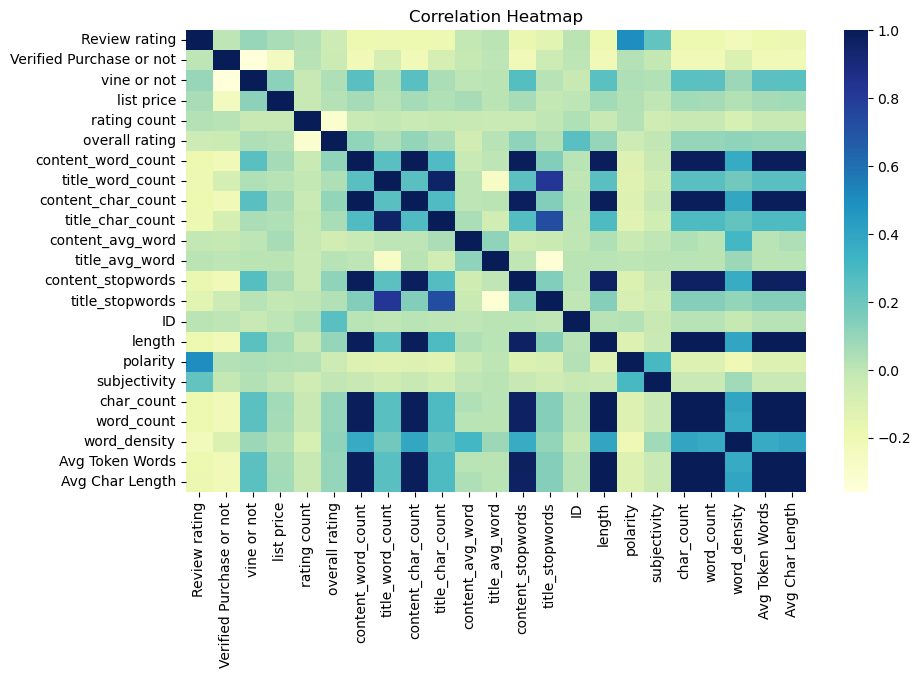

In [72]:
correlation_matrix = df_processed_full.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='YlGnBu') # Change annot to True to see values
plt.title('Correlation Heatmap')
plt.show()

<font color=#61BEB0>**People Find Helpful Distribution:**</font>

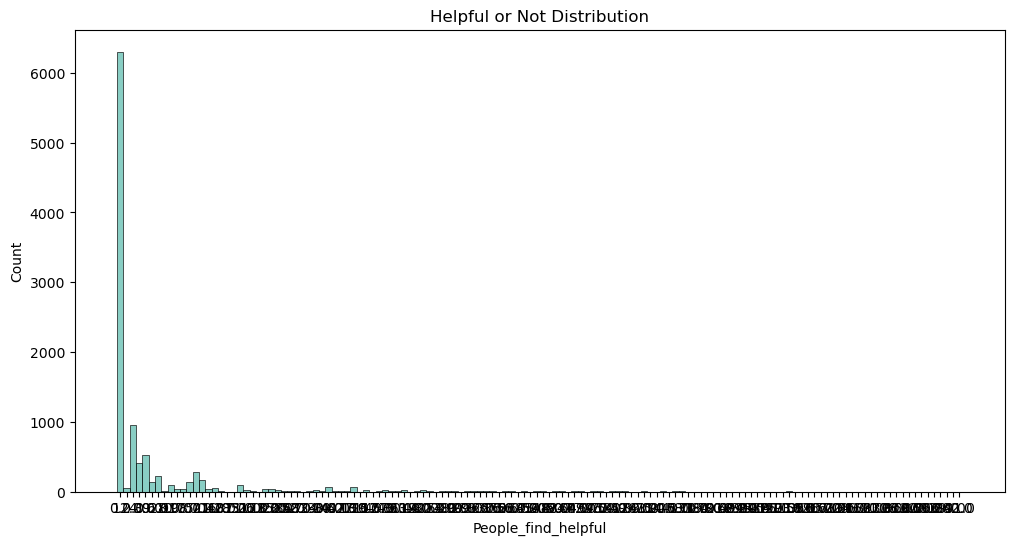

In [73]:
plt.figure(figsize=(12, 6))
sns.histplot(df_processed_full['People_find_helpful'], bins=20, kde=False, color = '#61BEB0')
plt.title('Helpful or Not Distribution')
plt.show()

<font color=#61BEB0>**List Price Distribution:**</font>

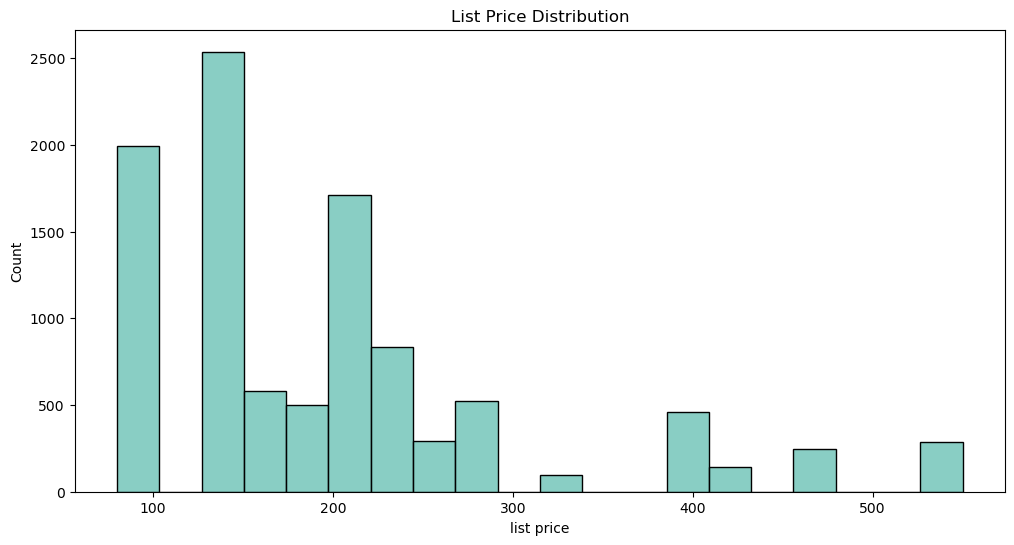

In [74]:
plt.figure(figsize=(12, 6))
sns.histplot(df_processed_full['list price'], bins=20, kde=False, color = '#61BEB0')
plt.title('List Price Distribution')
plt.show()

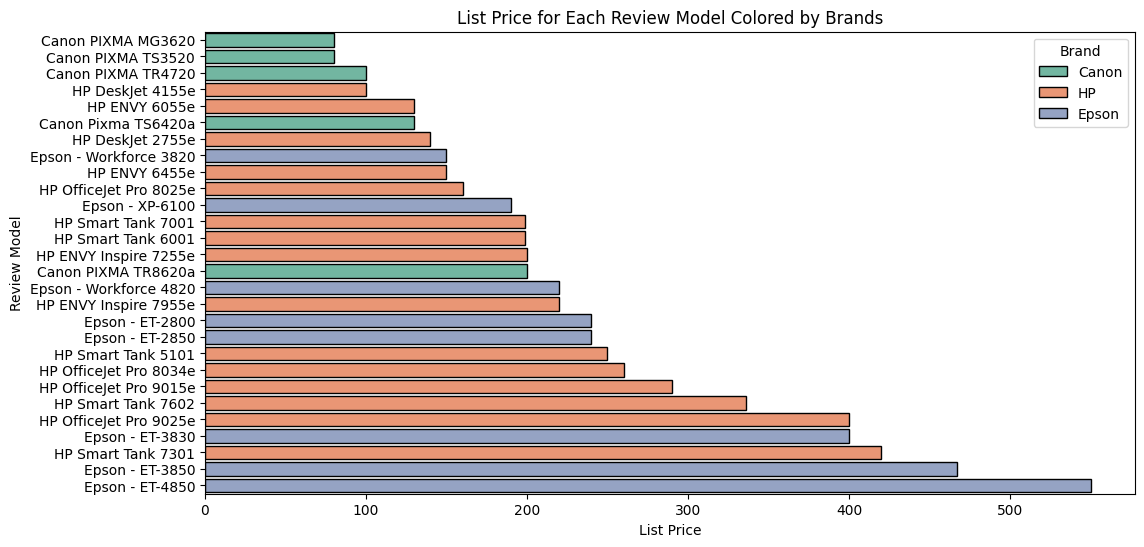

In [119]:
# Group the dataset by Brand and Review Model and calculate the median list price
result = df_processed_full.groupby(["Brand", "Review Model"])["list price"].median().reset_index()

# Sort the DataFrame by ascending list price
result = result.sort_values(by="list price")

plt.figure(figsize=(12, 6))
sns.barplot(data=result, x="list price", y="Review Model", hue="Brand", edgecolor = 'black', palette="Set2")
plt.xlabel("List Price")
plt.ylabel("Review Model")
plt.title("List Price for Each Review Model Colored by Brands")

plt.show()